# 4

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt

## 4.1 Examine Dataset

In [2]:
cora = Planetoid(root='/tmp/Cora', name='Cora')
n_train = cora[0].train_mask.sum().item()
n_val = cora[0].val_mask.sum().item()
n_test = cora[0].test_mask.sum().item()
print('There are %d/%d/%d nodes in the train/validation/test set of Cora' % (n_train, n_val, n_test))

There are 140/500/1000 nodes in the train/validation/test set of Cora


In [3]:
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
data_size = len(enzymes)
n_train = int(data_size * 0.8)
n_test = data_size - n_train
print('There are %d/%d graphs in the train/test set of ENZYMES' % (n_train, n_test))

There are 480/120 graphs in the train/test set of ENZYMES


There are 1000 nodes in the test set of Cora.  
There are 120 graphs in the test set of ENZYMES. 

## 4.2 GNN Implementation

### (i) GNN Stack
For node classification task on Cora, we follow the instructions. There are `num_layers` graph convolutional layers followed by a postprocessing multi-layer perceptron (Post-MLP). The structure of each graph convolutional layer is
$$
\text{GConv} \to \text{ReLU} \to \text{Dropout}
$$
And the stucture of the Post-MLP is
$$
\text{Linear} \to \text{Dropout} \to \text{Linear}
$$
without a non-linearity. 

The GNN Stack for graph classification on ENZYMES is slightly different from it for node classification. We add a graph pooling layer `global_add_pool` before the Post-MLP. 

Detailed implementation is in `GNNStack` in `models.py`

### (ii) GraphSAGE
The process of GraphSAGE is 
$$
\begin{aligned}
\mathbf{h}_{\mathcal{N}(v)}^{k} & \leftarrow \text{AGGREGATE}_{k}\left(\left\{\mathbf{h}_{u}^{k-1}, \forall u \in \mathcal{N}(v)\right\}\right) \\
\mathbf{h}_{v}^{k} & \leftarrow \sigma\left(\mathbf{W}^{k} \cdot \text{CONCAT}\left(\mathbf{h}_{v}^{k-1}, \mathbf{h}_{\mathcal{N}(v)}^{k}\right)\right) \\
\mathbf{h}_{v}^{k} & \leftarrow \mathbf{h}_{v}^{k} /\left\|\mathbf{h}_{v}^{k}\right\|_{2}, \forall v \in \mathcal{V}
\end{aligned}
$$

In the homework, we are told to use a dense layer followed by a ReLU non-linearity and a mean aggregator for the $\text{AGGREGATE}$ function. When ignoring the bias
$$
\text{AGGREGATE}_{k}\left(\left\{\mathbf{h}_{u}^{k-1}, \forall u \in \mathcal{N}(v)\right\}\right) = \text{MEAN}\left(\left\{\sigma\left(\mathbf{W}_{\text{agg}}^{k} \cdot\mathbf{h}_{u}^{k-1}\right), \forall u \in \mathcal{N}(v)\right\}\right)
$$

Plugging this into the template of Message Passing layer in PyTorch Geometric
$$
\mathbf{x}_{i}^{(k)}=\gamma^{(k)}\left(\mathbf{x}_{i}^{(k-1)}, \square_{j \in \mathcal{N}(i)} \phi^{(k)}\left(\mathbf{x}_{i}^{(k-1)}, \mathbf{x}_{j}^{(k-1)}, \mathbf{e}_{j, i}\right)\right)
$$

We got  
preprocessing message: 
$$
\mathbf m_i = \sigma\left(W_{\text{agg}}^{(k)} \cdot \mathbf{x}_i^{(k-1)}\right)
$$
`message` function is built-in default `message`:  
$$
\mathbf m_{j\to i}^{(k)} = \mathbf m_j
$$
`aggregate` is built-in `mean`:  
$$
\mathbf{x}_{\mathcal{N}(i)}^{k} = \text{MEAN}\left( \mathbf m_{j\to i}^{(k)}, \forall j \in \mathcal{N}(i) \right)
$$
`update`: 
$$
\begin{aligned}
\mathbf{x}_{i}^{k} & \leftarrow \sigma\left(\mathbf{W}^{k} \cdot \text{CONCAT}\left(\mathbf{x}_{i}^{k-1}, \mathbf{x}_{\mathcal{N}(i)}^{k}\right)\right) \\
\mathbf{x}_{i}^{k} & \leftarrow \mathbf{x}_{i}^{k} /\left\|\mathbf{x}_{i}^{k}\right\|_{2}, \forall i \in \mathcal{V}
\end{aligned}
$$
While implementing, we use `Linear` instead of the matrix multiplication. And we pull the code from `update` to `forward` in order to simplify the implementation. 

Detailed implementation is in `GraphSage` in `models.py`

Note the this implementation is different from the mean aggregator in GraphSAGE paper. 

### (iii) GAT
The process of GAT is
$$
\begin{aligned}
e_{i j} &= a\left(\mathbf{W} \vec{h}_{i}, \mathbf{W} \vec{h}_{j}\right) = \text {LeakyReLU}\left(\overrightarrow{\mathbf{a}}^{T}\left[\mathbf{W} \vec{h}_{i} \| \mathbf{W} \vec{h}_{j}\right]\right) \\
\alpha_{i j} &= \operatorname{softmax}_{j}\left(e_{i j}\right)=\frac{\exp \left(e_{i j}\right)}{\sum_{k \in \mathcal{N}_{i}} \exp \left(e_{i k}\right)} \\
\vec{h}_{i}^{\prime} &= \|_{k=1}^{K} \sigma\left(\sum_{j \in \mathcal{N}_{i}} \alpha_{i j}^{k} \mathbf{W}^{k} \vec{h}_{j}\right) 
\end{aligned}
$$


We first process `x` throught a `Linear` layer.  
Then we compute $\alpha_ij$ (for $K$ heads) and multiply them with `x_j` in the `message` function.  
`aggregate` is built-in `add` (because we already compute the weights)  
`update` is the post-processing concat or mean in the head dimension.  
Note that in PyTorch Geometric 1.6.1 (newer than the one in the course), we can only propagate node feature in one dimension. So we concat features from multi-heads to propagate them.  
Detailed implementation is in `GAT` in `models.py`

## 4.3 Training

### (i) Plot Validation Accuracy

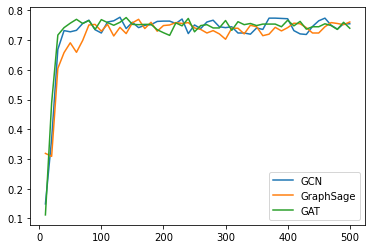

In [4]:
# Cora
for model_type in ['GCN', 'GraphSage', 'GAT']:
    with open('./p4/Cora_%s.log' % model_type, 'r') as f:
        A = f.readlines()
    valid_acc = [line.strip().split('\t') for line in A]
    valid_acc = [float(item[1]) for item in valid_acc if item[0] == 'test_acc']
    plt.plot(list(range(10, 501, 10)), valid_acc, label=model_type)

plt.legend(loc='lower right')
plt.show()

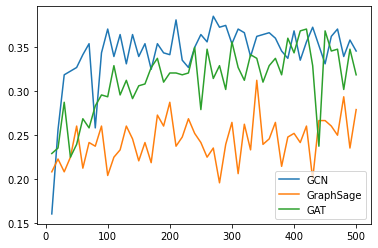

In [5]:
# ENZYMES
for model_type in ['GCN', 'GraphSage', 'GAT']:
    with open('./p4/ENZYMES_%s.log' % model_type, 'r') as f:
        A = f.readlines()
    valid_acc = [line.strip().split('\t') for line in A]
    valid_acc = [float(item[1]) for item in valid_acc if item[0] == 'test_acc']
    plt.plot(list(range(10, 501, 10)), valid_acc, label=model_type)

plt.legend(loc='lower right')
plt.show()